In [2]:
# Import the necessary librares for our work

from google.colab import drive

import numpy as np

import pandas as pd

import os

import h5py

import random

import time

import random

from PIL import Image

import tensorflow as tf
from keras import layers
from keras import models
from tensorflow.keras.preprocessing import image
from keras.utils import to_categorical

from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import graphviz

import warnings

reading image sample from the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This block of code is taken from the repository https://github.com/Yasser-A-Nizamli/Brain_tumors_classification
# The path to the folder containing all files in .mat format
inPath ="/content/drive/MyDrive/figshare/dataset_in_mat"

# The path to the folder where the gilioma images will be saved
outPath1 ="/content/drive/MyDrive/figshare/3classes/glioma"

# The path to the folder where the meningioma images will be saved
outPath2 ="/content/drive/MyDrive/figshare/3classes/meningioma"

# The path to the folder where the pituitary images will be saved
outPath3 ="/content/drive/MyDrive/figshare/3classes/pituitary"

for imagePath in os.listdir(inPath):
    # imagePath contains name of the image
    inputPath = os.path.join(inPath, imagePath)
    # Open mat file for reading
    f = h5py.File(inputPath, 'r')
    # Read cjdata struct
    cjdata = f['cjdata']
    # Get image label
    label = cjdata.get('label')[0,0]
    # Get image data and save it as numpy array
    image = np.array(cjdata.get('image')).astype(np.float64)
    # Close mat file
    f.close()

    # Normalize images so that the pixel intensity is within a range from 0 to 255
    hi = np.max(image)
    lo = np.min(image)
    image = (((image - lo)/(hi-lo))*255).astype(np.uint8)
    im = Image.fromarray(image)

    # If the label is equal to 1, the image will be saved in the meningioma folder
    # Saving the image with the jpg extension will ensure that the image is compressed using the jpeg algorithm and thus achieves memory efficiency
    if label == 1.0:
      fullOutPath = os.path.join(outPath2,imagePath)
      fullOutPath = fullOutPath[0:-3] + "jpg"
      im.save(fullOutPath)
    # If the label is equal to 1, the image will be saved in the glioma folder
    elif label==2.0:
      fullOutPath = os.path.join(outPath1,imagePath)
      fullOutPath = fullOutPath[0:-3] + "jpg"
      im.save(fullOutPath)
    # If the label is equal to 1, the image will be saved in the pituitary folder
    elif label==3.0:
      fullOutPath = os.path.join(outPath3,imagePath)
      fullOutPath = fullOutPath[0:-3] + "jpg"
      im.save(fullOutPath)

In [ ]:
# Obtain the path for each meningioma image and store it in a list
meningioma = [os.path.abspath(os.path.join('/content/drive/MyDrive/figshare/3classes/meningioma', p)) for p in os.listdir('/content/drive/MyDrive/figshare/3classes/meningioma')]

In [ ]:
# Obtain the path for each glioma image and store it in a list
glioma = [os.path.abspath(os.path.join('/content/drive/MyDrive/figshare/3classes/glioma', p)) for p in os.listdir('/content/drive/MyDrive/figshare/3classes/glioma')]

In [ ]:
# Obtain the path for each pituitary image and store it in a list
pituitary = [os.path.abspath(os.path.join('/content/drive/MyDrive/figshare/3classes/pituitary', p)) for p in os.listdir('/content/drive/MyDrive/figshare/3classes/pituitary')]

In [5]:
# Print the number of items in the glioma list
print(len(glioma))

1426


In [6]:
# Print the number of items in the pituitary list
print(len(pituitary))

930


In [7]:
# Print the number of items in the meningioma list
print(len(meningioma))

708


#Feature extraction

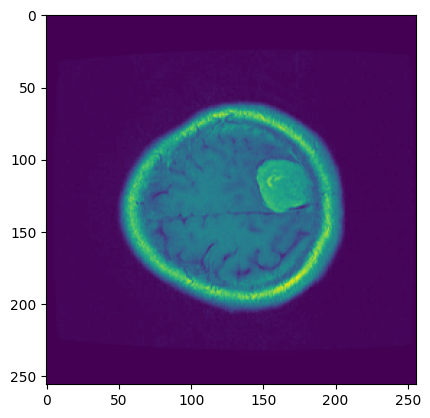

In [11]:
img = image.load_img(meningioma[4],color_mode='grayscale', target_size=(256, 256))
plt.imshow(img)


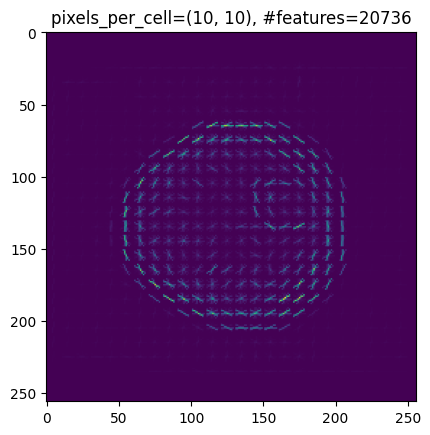

In [13]:
img = image.load_img(meningioma[4],color_mode='grayscale', target_size=(256, 256))
fd1, hog_image= hog(img, orientations=9, pixels_per_cell=(10, 10),block_norm='L2', cells_per_block=(2,2), visualize=True)
plt.title("pixels_per_cell=(10, 10), #features="+ str(fd1.shape[0]))
plt.imshow(hog_image)

Set up the feature extractor

In [17]:

def get_features(img_path):
    '''
    Parameters
    img_path : Path to the image from which features are to be extracted.
    -----------------------------------------------------------------------------
    Output
    numerical_features : numerical representation of the image.
    '''
    img = image.load_img(img_path,color_mode='grayscale', target_size=(256, 256))
    fd= hog(img, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), block_norm='L2', visualize=False)
    return np.reshape(fd, (1, 20736))


In [18]:
# Number of features per image
n = 20736

In [19]:
# featuresv saves the features extracted from images
# labels stores the class label of each image
featuresv = []
labels = []

In [20]:
# Iterate through the elements in the glioma image directory to extract features and labels
i=0
for image_path in glioma:

    if i  == 0:
      featuresv = np.reshape(get_features(image_path), (1, n))
    else:
      featuresv = np.append(featuresv,np.reshape(get_features(image_path), (1, n)), axis=0)

    labels.append('glioma')
    i+=1

In [21]:
# Iterate through the elements in the meningioma image directory to extract features and labels
for image_path in meningioma:

    featuresv = np.append(featuresv,np.reshape(get_features(image_path), (1, n)), axis=0)

    labels.append('meningioma')


In [22]:
# Iterate through the elements in the pituitary image directory to extract features and labels
for image_path in pituitary:

    featuresv = np.append(featuresv,np.reshape(get_features(image_path), (1, n)), axis=0)

    labels.append('pituitary')

In [23]:
# Print the dimensions of the features matrix
print(featuresv.shape)

(3064, 20736)


In [24]:
# Print the length of the target matrix
print(len(labels))

3064


In [25]:
featuresf = featuresv
labelsf = labels

In [26]:
# Converting the target variable from categorical form to numerical
labelsf = [int(0) if x=='meningioma' else x for x in labelsf]
labelsf= [int(1) if x=='glioma' else x for x in labelsf]
labelsf= [int(2) if x=='pituitary' else x for x in labelsf]

In [27]:
# Feature optimization using PCA
pca = PCA(n_components= 100, random_state=42)
featuresf2 = pca.fit_transform(featuresf)

In [28]:
# Split the dayaset into train and test subsets
X_train, X_test,  y_train, y_test = train_test_split(featuresf2, labelsf ,  random_state=42,   test_size=0.20,   shuffle=True)

#Classification using DNN

##Building the neural network structure

In [29]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(42)
   np.random.seed(42)
   random.seed(42)

In [30]:

tf.random.set_seed(42)
reset_random_seeds()


y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)

model = models.Sequential()

model.add(layers.Input(shape=(100,)))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

batch_size = 16
epochs = 300


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1000)                │         101,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1000)                │       1,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │         100,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 25)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 25)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 25)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │              78 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,223,103 (4.67 MB)

 Trainable params: 1,223,103 (4.67 MB)

 Non-trainable params: 0 (0.00 B)

##Training and testing the developed neural network

In [31]:
history = model.fit(X_train, y_train_c, validation_data=(X_test, y_test_c),
          batch_size=batch_size,
          epochs=epochs,
          verbose=2)

test_loss, test_acc = model.evaluate(X_test, y_test_c)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Epoch 1/300
154/154 - 8s - 55ms/step - accuracy: 0.6393 - loss: 0.8000 - val_accuracy: 0.8728 - val_loss: 0.5308
Epoch 2/300
154/154 - 5s - 30ms/step - accuracy: 0.7446 - loss: 0.6111 - val_accuracy: 0.9005 - val_loss: 0.3361
Epoch 3/300
154/154 - 5s - 35ms/step - accuracy: 0.7789 - loss: 0.5540 - val_accuracy: 0.9086 - val_loss: 0.2860
Epoch 4/300
154/154 - 8s - 53ms/step - accuracy: 0.8062 - loss: 0.4884 - val_accuracy: 0.9135 - val_loss: 0.2430
Epoch 5/300
154/154 - 5s - 31ms/step - accuracy: 0.8201 - loss: 0.4601 - val_accuracy: 0.9070 - val_loss: 0.2611
Epoch 6/300
154/154 - 4s - 24ms/step - accuracy: 0.8286 - loss: 0.4232 - val_accuracy: 0.9119 - val_loss: 0.2275
Epoch 7/300
154/154 - 3s - 21ms/step - accuracy: 0.8458 - loss: 0.4168 - val_accuracy: 0.9119 - val_loss: 0.2098
Epoch 8/300
154/154 - 6s - 38ms/step - accuracy: 0.8409 - loss: 0.3977 - val_accuracy: 0.9233 - val_loss: 0.1841
Epoch 9/300
154/154 - 5s - 35ms/step - accuracy: 0.8462 - loss: 0.3765 - val_accuracy: 0.9168 - 

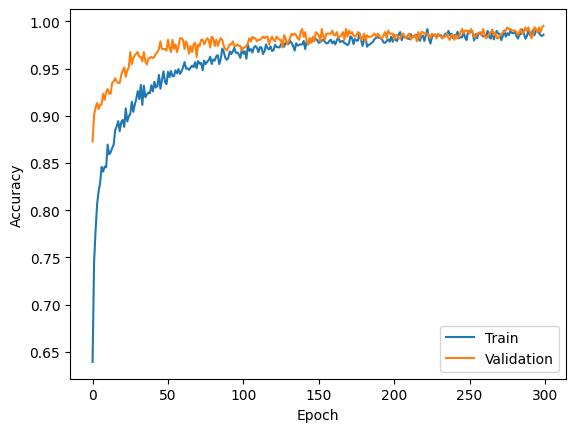

In [32]:
# Accuracy versus iterations curve for the proposed neural model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

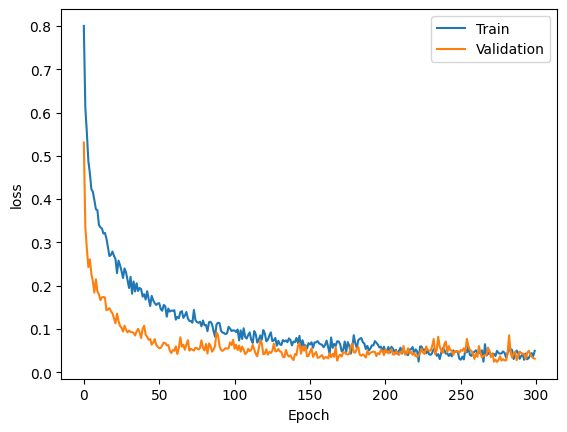

In [33]:
# Loss versus iterations curve of the proposed neural model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [34]:
# Display the classificarion report
y_predict = model.predict(X_test)
y_predict_dnn =[]
for i in range(y_predict.shape[0]):
    y_predict_dnn.append(list(y_predict[i]).index(max(list(y_predict[i]))))
print(classification_report(y_test, y_predict_dnn,digits=4))

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
              precision    recall  f1-score   support

           0     0.9930    0.9860    0.9895       143
           1     0.9932    0.9966    0.9949       293
           2     1.0000    1.0000    1.0000       177

    accuracy                         0.9951       613
   macro avg     0.9954    0.9942    0.9948       613
weighted avg     0.9951    0.9951    0.9951       613



In [35]:
# Third party function for a fancy drawing of the confusion matrix.

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==20:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                precision,recall,f1_score)
        else:
            #stats_text = "\n\nAccuracy={:0.4f}".format(accuracy)
            pass
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)
sns.set_context('talk')

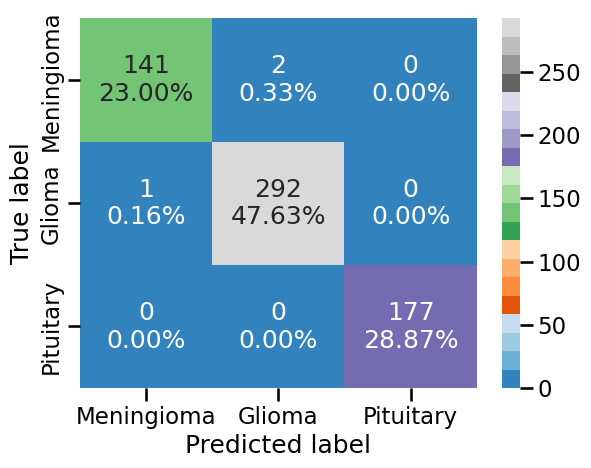

In [36]:
# Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_predict_dnn)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Meningioma', 'Glioma', 'Pituitary']
make_confusion_matrix(cf_matrix, group_names=labels, categories=categories, cmap='tab20c')

#Comparison of classification performance for different models

In [37]:
svm_rbf = SVC(kernel='linear', random_state=42)
svm_rbf.fit(X_train, y_train)
y_predict_svc_linear = svm_rbf.predict(X_test)
accuracy_svc_linear = round(accuracy_score(y_test, y_predict_svc_linear)*100, 2)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_predict_lr = lr.predict(X_test)
accuracy_lr = round(accuracy_score(y_test, y_predict_lr)*100, 2)

rf = RandomForestClassifier(n_estimators=200, max_depth=100,criterion='gini', random_state=42)
rf.fit(X_train, y_train)
y_predict_rf = rf.predict(X_test)
accuracy_rf = round(accuracy_score(y_test, y_predict_rf)*100, 2)

accuracy_dnn = round(accuracy_score(y_test, y_predict_dnn)*100, 2)

dt = DecisionTreeClassifier(max_depth=200,criterion='gini', random_state=42)
dt.fit(X_train, y_train)
y_predict_dt = dt.predict(X_test)
accuracy_dt = round(accuracy_score(y_test, y_predict_dt)*100, 2)


svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train, y_train)
y_predict_svc_rbf = svm_rbf.predict(X_test)
accuracy_svc_rbf = round(accuracy_score(y_test, y_predict_svc_rbf)*100, 2)


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_predict_knn = knn.predict(X_test)
accuracy_knn = round(accuracy_score(y_test, y_predict_knn)*100, 2)


nb = GaussianNB()
nb.fit(X_train, y_train)
y_predict_nb = nb.predict(X_test)
accuracy_nb = round(accuracy_score(y_test, y_predict_nb)*100, 2)

In [38]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

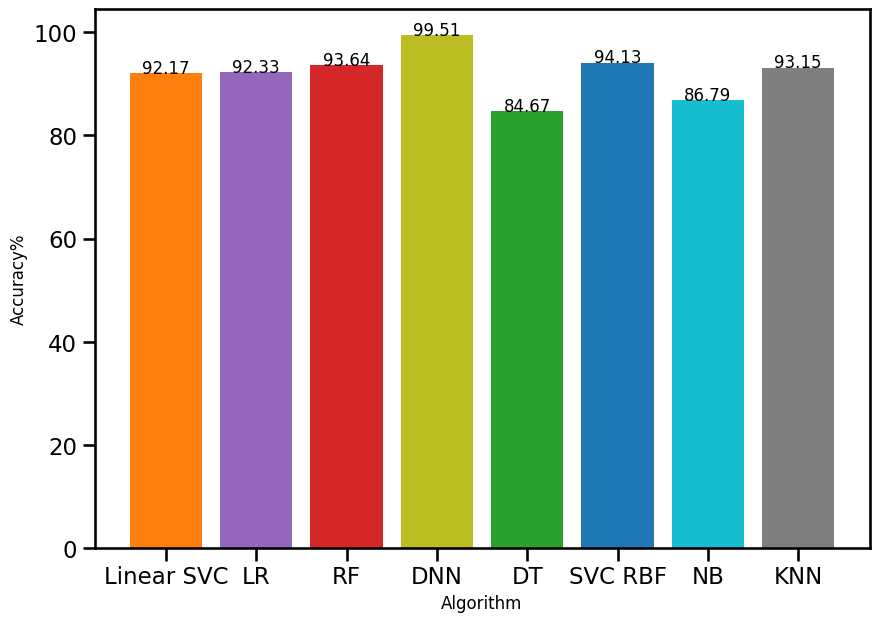

In [39]:

fig, ax = plt.subplots(figsize=(10, 7))

font = {
        'size'   : 12}
plt.rc('font', **font)

alg = ['Linear SVC', 'LR', 'RF', 'DNN', 'DT', 'SVC RBF', 'NB', 'KNN']
counts = [accuracy_svc_linear, accuracy_lr, accuracy_rf, accuracy_dnn, accuracy_dt, accuracy_svc_rbf ,accuracy_nb, accuracy_knn]

bar_colors = ['tab:orange', 'tab:purple', 'tab:red', 'tab:olive', 'tab:green','tab:blue' , 'tab:cyan', 'tab:gray']

ax.bar(alg, counts, color=bar_colors)
addlabels(alg, counts)
ax.set_ylabel('Accuracy%',fontsize=12 )
ax.set_xlabel('Algorithm',fontsize=12 )

plt.show()
